In [1]:
import argparse
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# 读取数据
数据来源：obj-aug

In [3]:
x_list = []
y_list = []
for pic in tqdm(os.listdir('obj-aug')):
    pic_path = './obj-aug/' + pic
    # 读取RGB三通道图像(640, 640, 3)
    pic_data = cv2.imread(pic_path, cv2.IMREAD_COLOR)
    x_list.append(pic_data)
    y_list.append(int(pic[:2]))
x_list = np.array(x_list)  # (15000, 640, 640, 3)
y_list_int = np.array(y_list)
y_list = np.eye(19)[y_list_int - 1] # (15000, 19)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

# 假设标签数据保存在label_list中，其中每个标签是一个整数
X = x_list
y = y_list

# 分层抽样，其中train_size和test_size分别表示训练集和测试集的比例
# n_splits表示抽取的次数，random_state表示随机数种子
split = StratifiedShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=42)
train_index, test_index = next(split.split(X, y))

# 得到训练集和测试集
X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

# 将训练集进一步划分为训练集和验证集，其中test_size表示验证集的比例
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, valid_index = next(split.split(X_train, y_train))

# 得到训练集、验证集和测试集的索引
train_index = [train_index[i] for i in range(len(train_index))]
valid_index = [valid_index[i] for i in range(len(valid_index))]
test_index = [test_index[i] for i in range(len(test_index))]

# 分类器

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm, trange

# 定义超参数
batch_size = 8
learning_rate = 0.0001
num_epochs = 100

# 设置 GPU
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

writer = SummaryWriter()

class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

# 加载数据集
train_data = x_list[train_index]
train_labels = y_list[train_index]
valid_data = x_list[valid_index]
valid_labels = y_list[valid_index]
test_data = x_list[test_index]
test_labels = y_list[test_index]

# # 定义数据增强和标准化
transform = transforms.Compose([
#     transforms.RandomAffine(5),
#     transforms.ColorJitter(hue=.05, saturation=.05),
#     transforms.RandomCrop((88, 88)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
    transforms.ToTensor(), # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 标准化张量
])

# 加载数据集
train_dataset = MyDataset(train_data, train_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = MyDataset(valid_data, valid_labels, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MyDataset(test_data, test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 定义模型
class MyModel(nn.Module):
    def __init__(self, num_classes=19):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=128 * 80 * 80, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 80 * 80)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MyModel(num_classes=19)
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
writer = SummaryWriter()
writer.add_graph(model, input_to_model=torch.rand(batch_size, 3, 640, 640,).to(device))

In [ ]:
# 训练模型
for epoch in trange(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (np.array(predicted.cpu()) == np.argwhere(np.array(labels.cpu())==1)[:, 1]).sum().item()
    epoch_loss = running_loss / len(train_dataset)
    print('Epoch [%d/%d], Loss: %.4f' % (epoch + 1, num_epochs, epoch_loss))
    torch.save(model.state_dict(), "./classifier/model-CNN/epoch-%d.pt" % epoch)
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/train', 100 * correct / total, epoch)
    
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (np.array(predicted.cpu()) == np.argwhere(np.array(labels.cpu())==1)[:, 1]).sum().item()
        epoch_loss = running_loss / len(valid_dataset)
        print('Accuracy of the model on the valid images: %d %%' % (100 * correct / total))
    writer.add_scalar('Loss/valid', epoch_loss, epoch)
    writer.add_scalar('Accuracy/valid', 100 * correct / total, epoch)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.4229


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 79 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [2/100], Loss: 0.1397


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 82 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [3/100], Loss: 0.0675


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 80 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [4/100], Loss: 0.0329


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 75 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [5/100], Loss: 0.0367


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 83 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [6/100], Loss: 0.0348


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 82 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [7/100], Loss: 0.0149


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [8/100], Loss: 0.0299


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 80 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [9/100], Loss: 0.0095


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [10/100], Loss: 0.0245


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [11/100], Loss: 0.0006


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [12/100], Loss: 0.0001


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [13/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [14/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [15/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [16/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [17/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [18/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [19/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [20/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [21/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [22/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [23/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [24/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [25/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [26/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [27/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [28/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 85 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [29/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [30/100], Loss: 0.0504


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 79 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [31/100], Loss: 0.0061


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 83 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [32/100], Loss: 0.0140


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 83 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [33/100], Loss: 0.0001


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [34/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [35/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [36/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [37/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [38/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [39/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [40/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [41/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [42/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [43/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [44/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [45/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [46/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [47/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [48/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 83 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [49/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 84 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [50/100], Loss: 0.0390


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 78 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [51/100], Loss: 0.0109


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 81 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [52/100], Loss: 0.0003


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 83 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [53/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 83 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [54/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 83 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [55/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 83 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [56/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 82 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [57/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 83 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [58/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 82 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [59/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 82 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [60/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 82 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [61/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 83 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [62/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 82 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [63/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 82 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [64/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 82 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [65/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 82 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [66/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy of the model on the valid images: 82 %


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [67/100], Loss: 0.0000


  0%|          | 0/300 [00:00<?, ?it/s]

In [9]:
y_pred = []
y_true = []
# 测试模型
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted)
        y_true.append(np.argwhere(np.array(labels.cpu())==1)[:, 1])
        total += labels.size(0)
        correct += (np.array(predicted.cpu()) == np.argwhere(np.array(labels.cpu())==1)[:, 1]).sum().item()
    print('Accuracy of the model on the test images: %d %%' % (100 * correct / total))

  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy of the model on the test images: 93 %


# 评价

In [19]:
y_pred_list = []
y_true_list = []
for i in range(len(y_pred)):
    y_pred_list.append(np.array(y_pred[i].cpu()))
    y_true_list.append(np.array(y_true[i]))
y_pred_list = np.hstack(y_pred_list)
y_true_list = np.hstack(y_true_list)

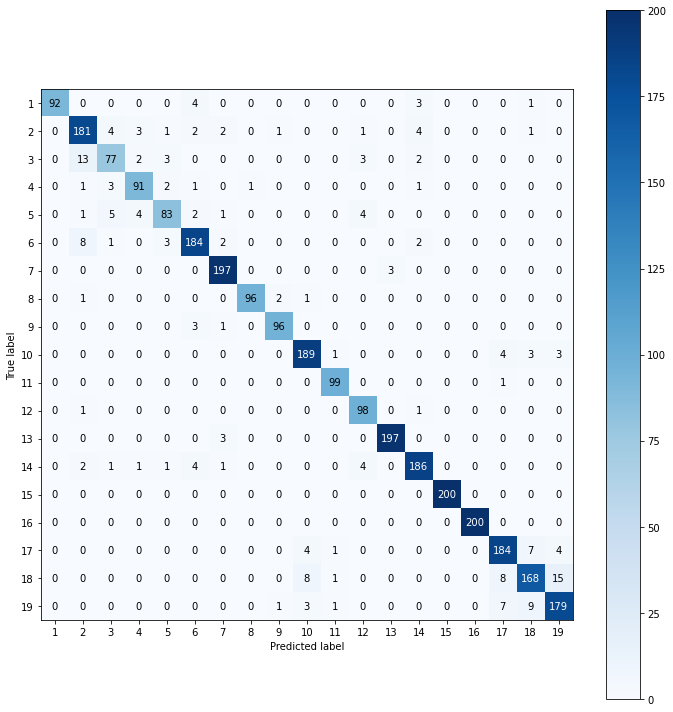

In [23]:
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(y_true_list, y_pred_list)

# 绘制混淆矩阵图
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=[str(i + 1) for i in range(19)],
       yticklabels=[str(i + 1) for i in range(19)],
       xlabel='Predicted label',
       ylabel='True label')

# 添加数值标签
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()